# Importing Libs

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import math

# JoyPy EDA with Continuous Variables (Ridgeline plots) Nice with Timeseries data for visualizing data in (daily/weekly/monthly/yearly) basis
!pip install joypy
!python -c "import joypy; print(joypy.__version__)"
import joypy

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import xgboost as xgb



0.2.6


# Loading Dataset

In [2]:
train_df = pd.read_csv("/kaggle/input/loan-approval-prediction-data/train.csv")
test_df = pd.read_csv("/kaggle/input/loan-approval-prediction-data/test.csv")

train_df

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0


In [3]:
ID = train_df['id']
train_df = train_df.drop('id', axis = 1)

# EDA

loan_status
0    50295
1     8350
Name: count, dtype: int64


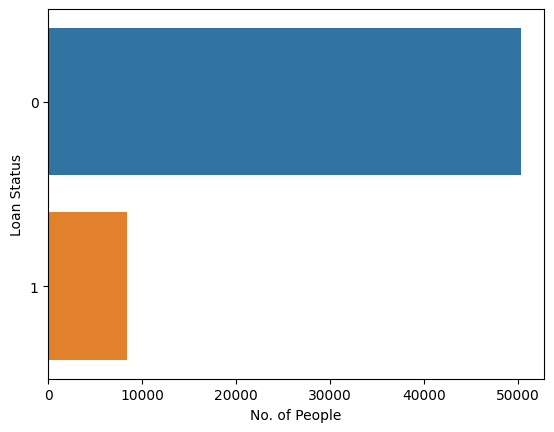

In [4]:
# Check distribution of target class
print(train_df['loan_status'].value_counts())

sns.countplot(y=train_df['loan_status'] ,data=train_df)
plt.xlabel("No. of People")
plt.ylabel("Loan Status")
plt.show()

I noticed that the data targets are imbalanced.
thats why we should use ***Startified Kfold!***

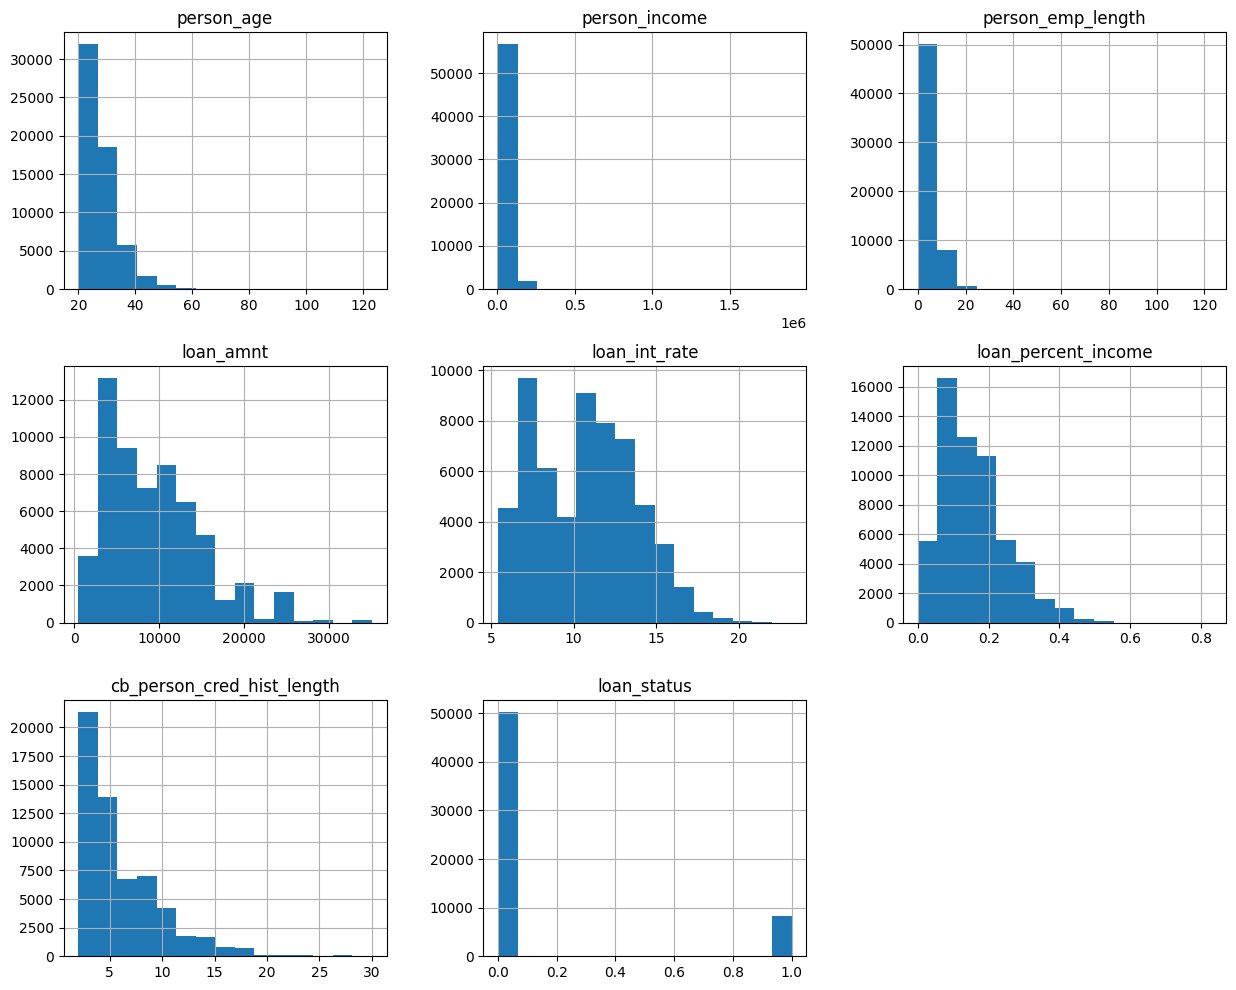

In [5]:
# Check the distribution of all the features
train_df.hist(figsize=(15,12),bins = 15)
plt.title("Features Distribution")
plt.show()

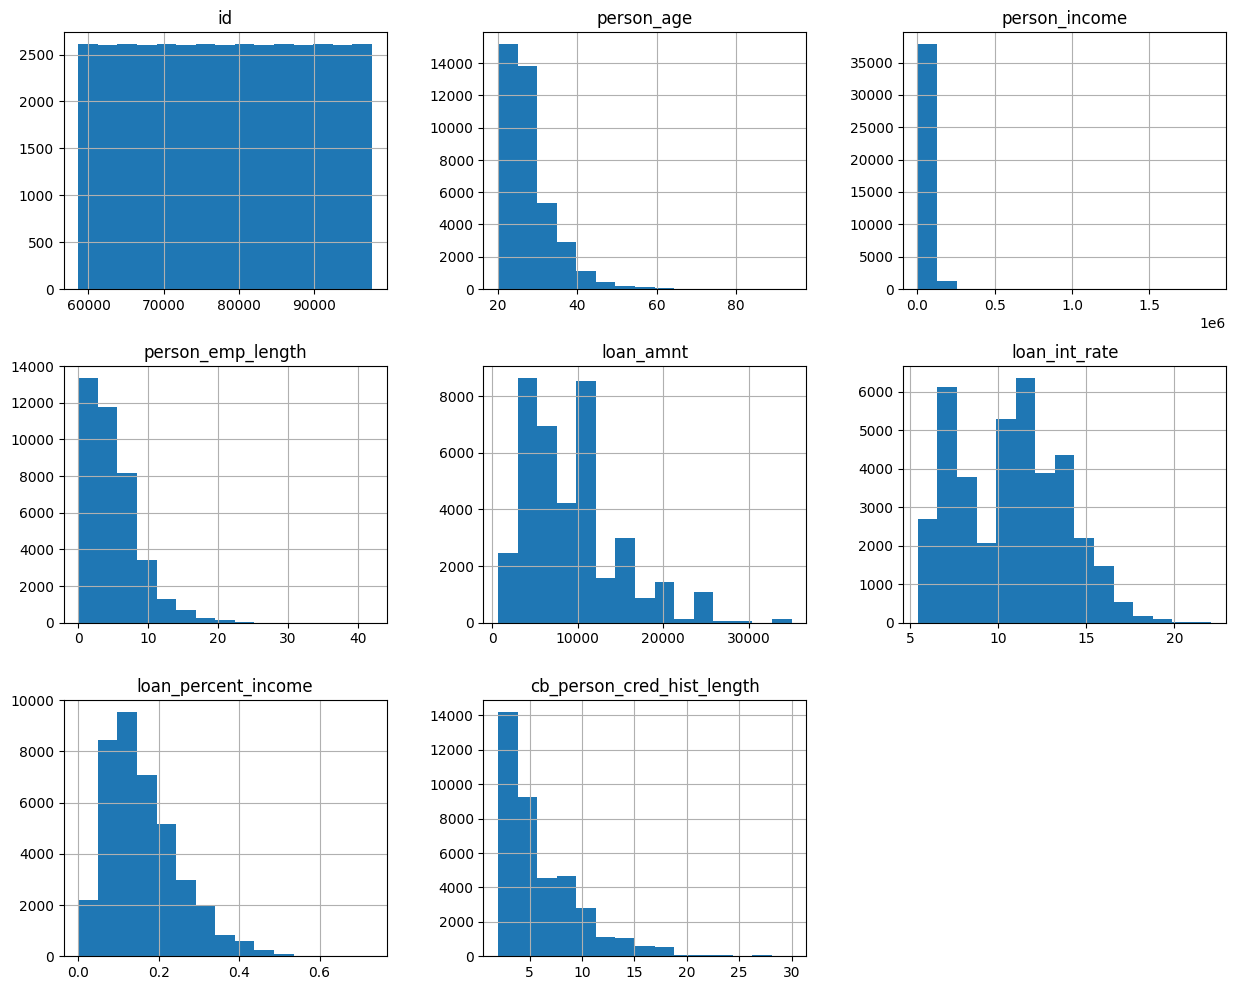

In [6]:
# Check the distribution of all the features
test_df.hist(figsize=(15,12),bins = 15)
plt.title("Features Distribution")
plt.show()

**What i Noticed:**
* preson_age has outliers after 60... so we can drop people with age > 60 


In [6]:
# Number of rows and columns in the plot
n_cols = 3
n_rows = math.ceil(len(train_df.columns.values)/n_cols)

IndexError: index 4 is out of bounds for axis 0 with size 4

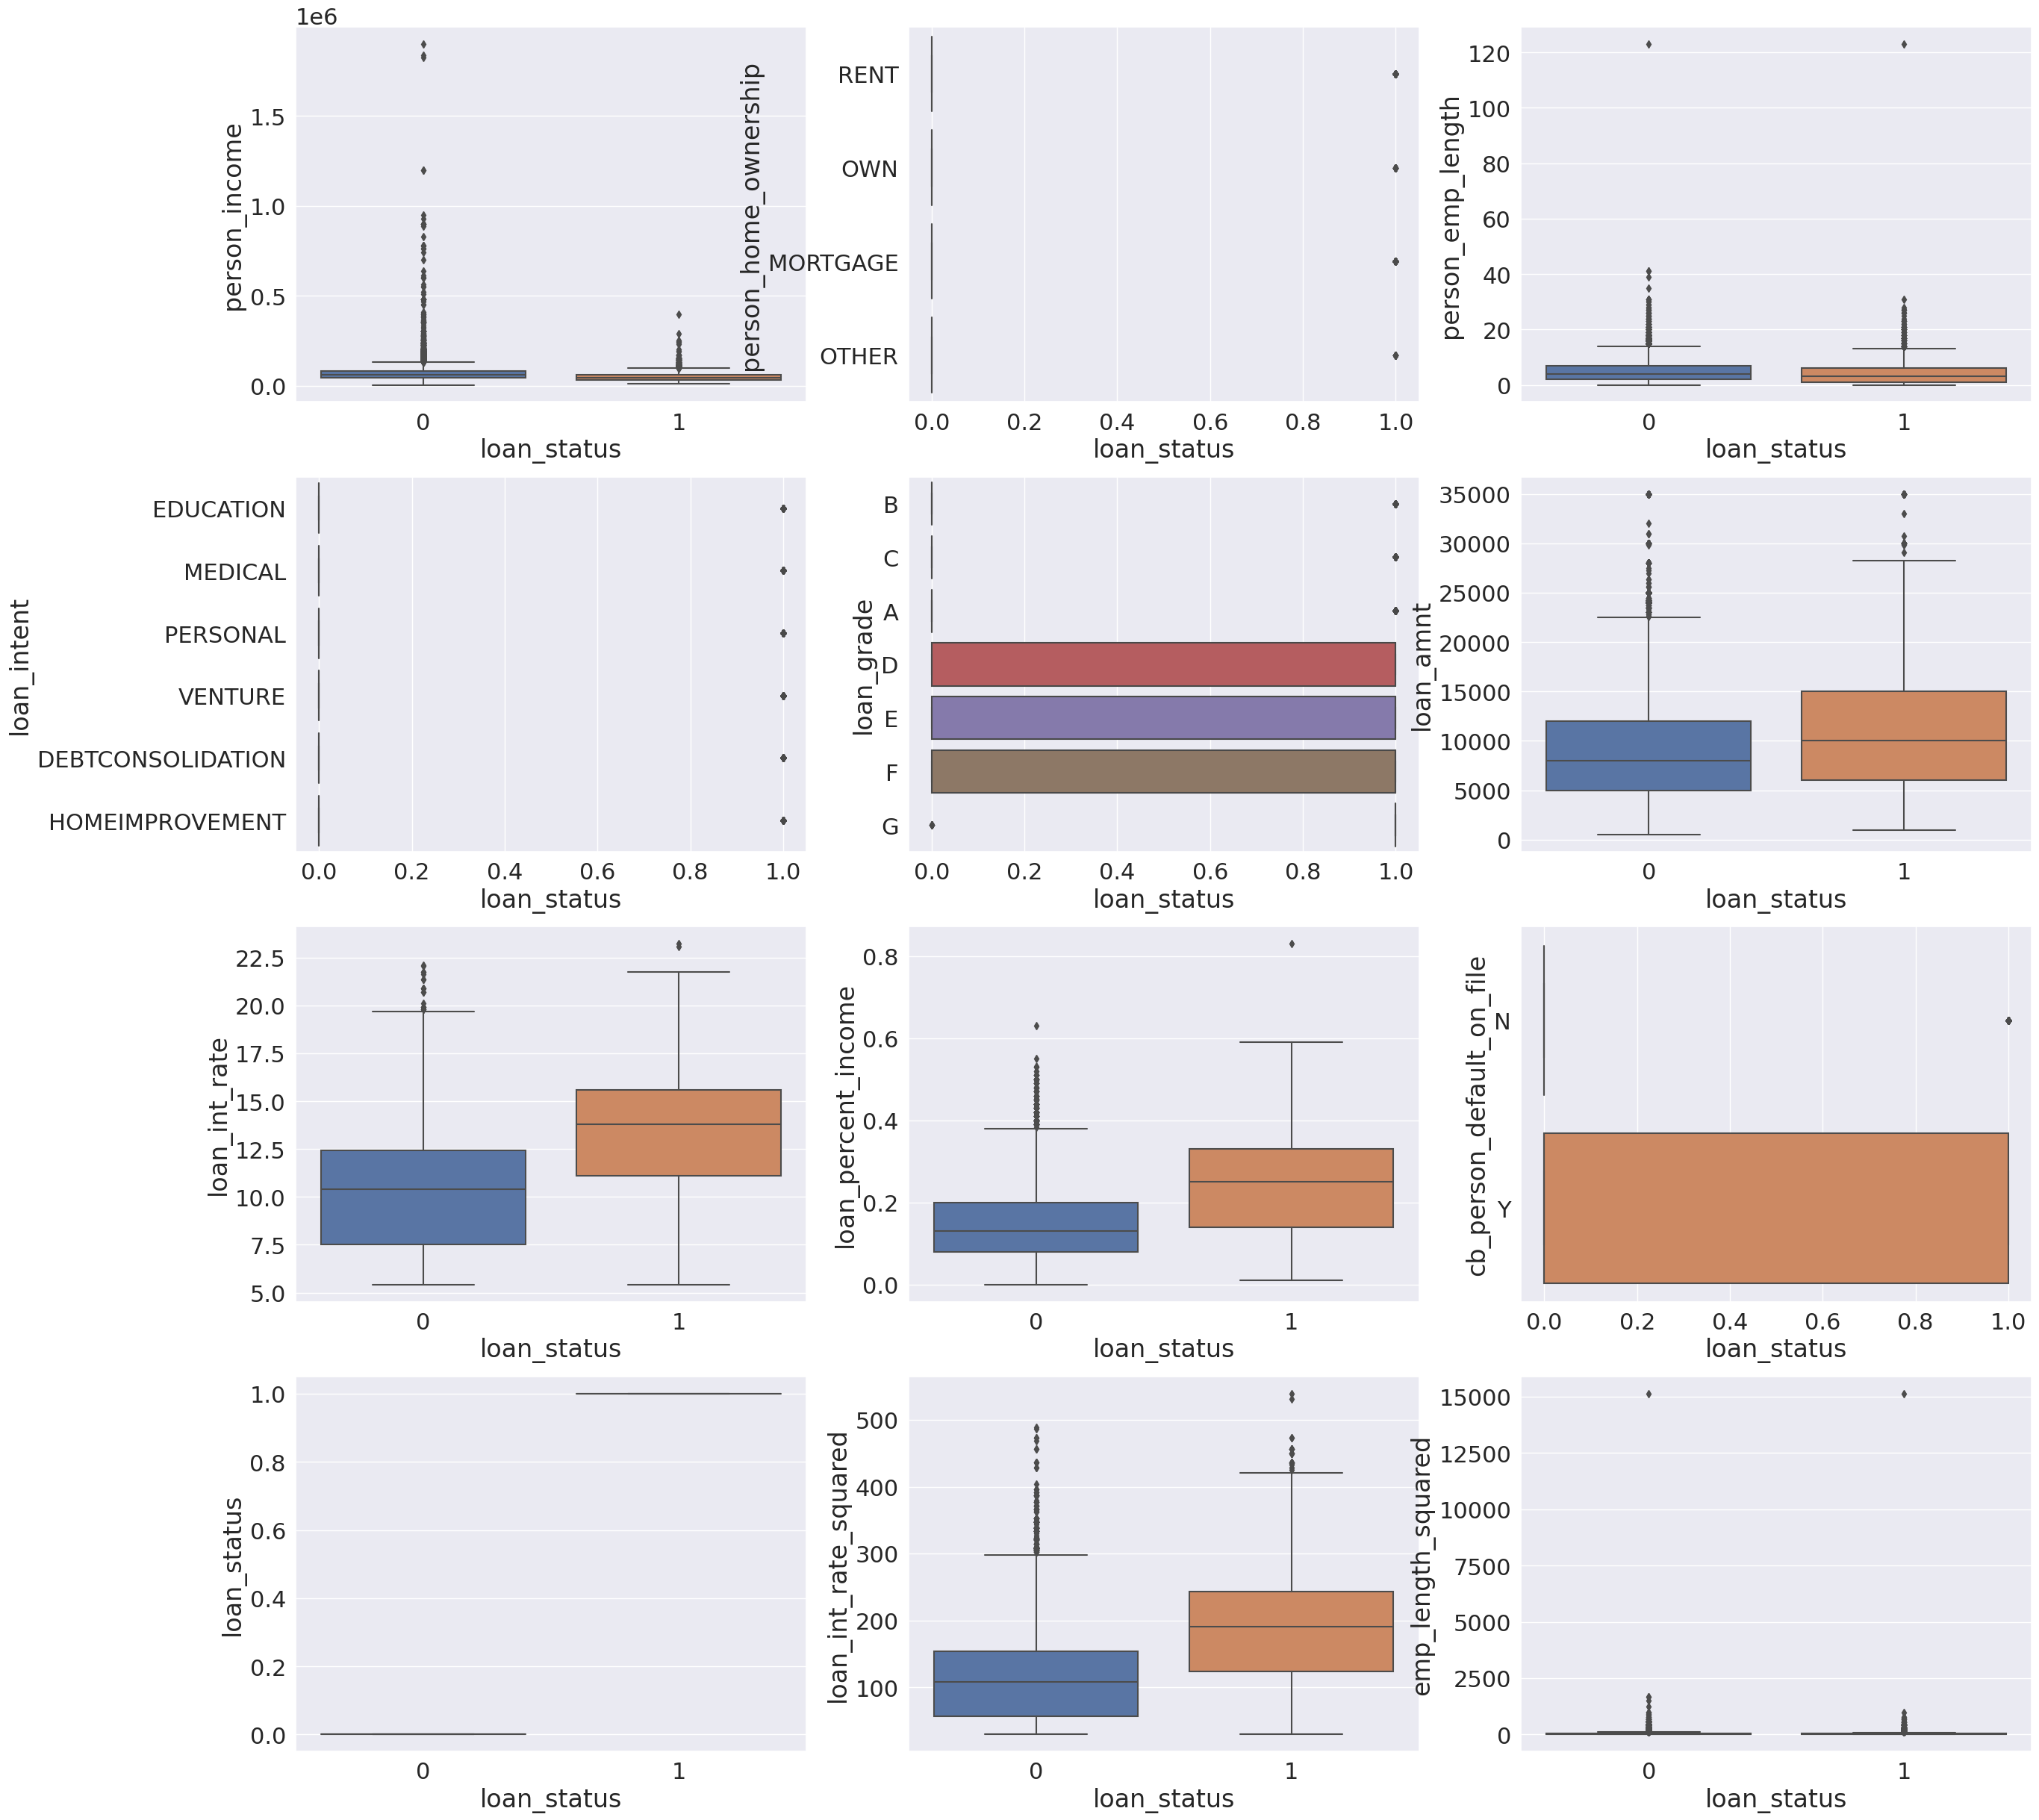

In [20]:
sns.set(font_scale=2)

# Check the distribution of y variable corresponding to every x variable 
fig,ax = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(30,30))
row = 0
col = 0
for i in train_df.columns.values:
    if col > 2:
        row += 1
        col = 0
    axes = ax[row,col]
    sns.boxplot(x = train_df['loan_status'], y = train_df[i], ax = axes)
    col += 1
plt.tight_layout()
plt.title("Individual Features by Class")
plt.show()

**Box Plots:**
* The box Indicates the range which the middle 50% of all data lies ( Interquartile range )
* Thus, the lower end of the box is the 1st quartile [q1] and the upper is the 3rd quartile [q3] ( 25% of the data are less than q1 and 25% of the data are greater than q3 )
* The Middle line is the Median 
* The T-shaped whiskers go to the last point which is still within 1.5x the Interquartile range
* Points that are further away are considered outliers

***Therefore, What I Notice:***
* About 50% of the people ages lie between 20 and 30.
* Ages Higher Than 40 are considered Outliers.
* **Age Dosen't seem to have a role in whether a person was able to approve his loan**.

* person_income seems to have an impact in loan approval because the box is higher in loan_status = 0 (Median and overall income is higher than loan_status = 1).

* Categorical Features (person_home_ownership, loan_intent) are less usefull predictors and doesn't seem to give any insights.

* **as Past Employment Length in year increases (person_emp_length) the person is more likely to approve the loan.**

* Loan Grades (loan_grade) **[ D, E, F] are most likely to NOT Approve the loan**.

* the Lesser (loan_amnt) the more likely the person approve the loan.
* **loan_amnt & loan_int_rate & loan_precent_income[person_income/loan_amount] seem to be coorelated (I can get their mean and add it as a feature)**

* Those how **have taken loans before are less likely to approve future loans**

* Credit History in Years doesn't seem to do any difference in loan approval!

In [ ]:
# Visualize / compare distributions
numeric_df = train_df.select_dtypes(include='number')
varbls = list(numeric_df.columns.values)

plt.figure(figsize=(10,2), dpi= 80)
for i,var in enumerate(varbls):
    joypy.joyplot(train_df, column=[var], by="loan_status", figsize=(16,5), color=['tomato', 'purple'], alpha = 0.85);
    plt.title(f"{var} by 'loan_status'", fontsize=22)
plt.show()

***What I Notice:***
* just as before age graphs seem Identical for both cases of approving and not approving the loan so that is clear...
* as The ratio of loan amount to the person's income (loan_percent_income) decreases its more likely that the person will approve the loan

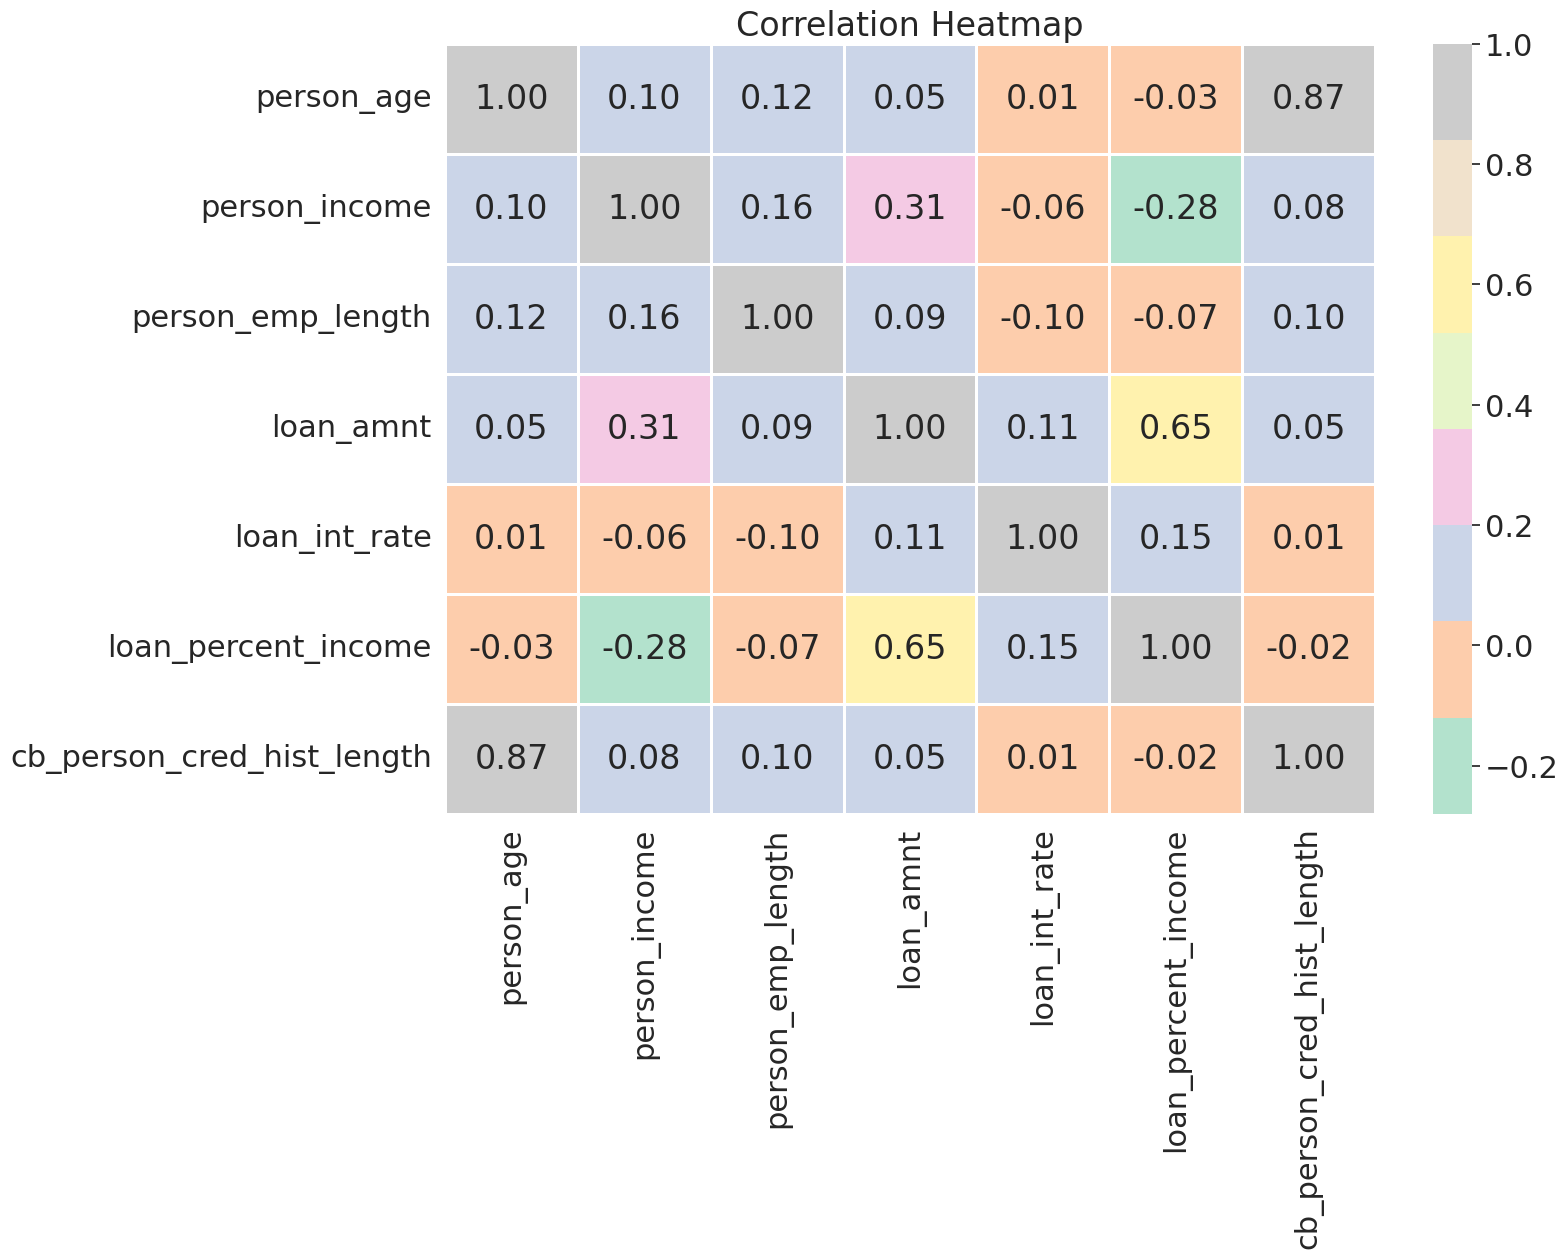

In [9]:
plt.figure(figsize=(15, 10))

# Using Seaborn to create a heatmap
sns.heatmap(numeric_df.drop('loan_status',axis=1).copy().corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

# Data Preprocessing
we can start applying our thoughts now
and maybe add some Feature Interactions along the way!

## TODO:
* Use Stratified Kfold
* try: remove (person_age) & (cb_person_cred_hist) as a feature (DONE)
* **Important features:**
    person_emp_length - loan_grade - loan_amnt - loan_int_rate & loan_precent_income[person_income/loan_amount] - cb_person_default_on_file
* **Coorelation Between**: (loan_amnt , loan_percent_income) ( loan_percent_income , loan_status )

# Adding Some Feature Interactions... :

In [10]:

for df in [train_df, test_df]:
    df.drop(columns=["person_age", 'cb_person_cred_hist_length'], axis=1, inplace=True)
    df['loan_int_rate_squared'] = df['loan_int_rate'] ** 2
    df['emp_length_squared'] = df['person_emp_length'] ** 2
    df['loan_amnt_to_income_ratio'] = df['loan_amnt'] / df['person_income']
    df['loan_int_rate_income_ratio'] = df['loan_int_rate'] / df['person_income']
    df['income_percentage_for_loan'] = df['loan_percent_income'] * 100
    df['monthly_income'] = df['person_income'] / 12
    df['monthly_debt'] = (df['loan_amnt'] + df['loan_int_rate'])
    df['debt_to_income'] = df['monthly_debt'] / df['monthly_income']

    
X = train_df.drop("loan_status", axis = 1).copy()
y = train_df["loan_status"].copy()

# Scaling Numerical Featrues & Encoding Categorical Ones:

In [11]:
numeric_features = ['person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb.XGBClassifier(n_estimators=100, objective='binary:logistic', tree_method='hist', eta=0.1, max_depth=7, enable_categorical=True))])

# Splitting Training & Testing Data:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting the Model and Seeing the results!

In [13]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.952


KeyError: 20

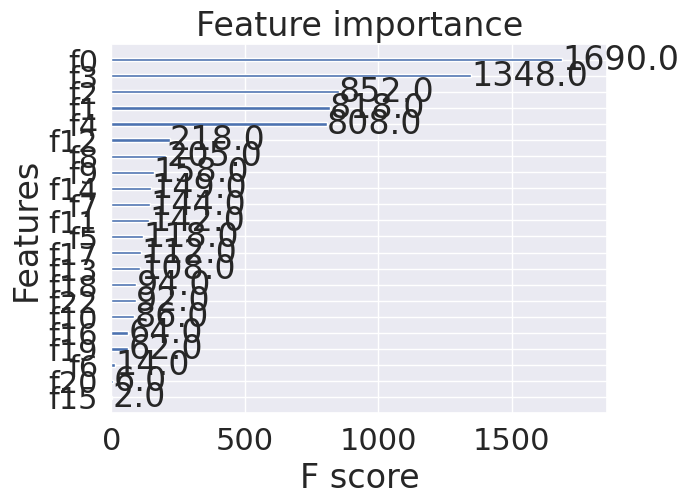

In [14]:
#  feature importance

feature_important = clf['classifier'].get_booster().get_score(importance_type='gain')
feature_names = X.columns
dict_features = dict(enumerate(feature_names))

# keys = list(feature_important.keys())
# #keys = list(feature_names.values)
# values = list(feature_important.values())

# data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
# data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

axsub = xgb.plot_importance(clf['classifier'])

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
lst_yticklabels = [ Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
lst_yticklabels = [ dict_features[int(i)] for i in lst_yticklabels]

axsub.set_yticklabels(lst_yticklabels)
print(dict_features)
plt.show()


In [ ]:
len(X.columns)

In [ ]:
len(list(feature_important.keys()))

# Submission File

In [ ]:
# y_pred = clf.predict(test_df)
# final_submission = pd.DataFrame({'id': test_df['id'], 'loan_status': y_pred})
# final_submission.to_csv('preprocessed_xgboost.csv', index=False